<a href="https://colab.research.google.com/github/Loggo-MediCare/python-numpy-stock/blob/main/success_for_8110_tw_20261128_%E7%9B%B8%E9%97%9C%E7%86%B1%E5%9C%96_%E5%A4%9A%E5%9B%A0%E5%AD%90%E7%9B%B8%E5%85%B3%E6%80%A7%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# -*- coding: UTF-8 -*-
"""
======================================================================
多因子相關性分析 (Correlated Factor Analysis)
目標：準備並計算華東 (8110.tw) 及其相關資產的相關性矩陣
======================================================================
"""
!pip install pandas numpy scikit-learn statsmodels matplotlib seaborn pandas-datareader yfinance TA-Lib arch
import numpy as np
import pandas as pd
# 使用 yfinance 代替 pandas_datareader.data 來下載股價數據
import yfinance as yf
import pandas_datareader.data as web # 仍然用於 FRED 數據 (如 VIX, 匯率)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# --- 1. 定義標的和因子 ---
TARGET_STOCK = '8110.TW'  # 華東
# 相關股票：台股大盤、同產業龍頭、重要客戶或供應商
STK_TICKERS = [TARGET_STOCK, '^TWII', 'MU', 'GOOGL']
# 貨幣對：使用美元/台幣 (TWD=X) 和美元/日圓 (日圓是亞洲電子業重要參考)
CCY_TICKERS = ['TWD=X', 'JPY=X']
# 指數：全球大盤、恐慌指數
IDX_TICKERS = ['^GSPC', 'VIXCLS'] # ^GSPC = S&P 500, VIXCLS = FRED VIX

# 數據週期 (5年)
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=365 * 5)).strftime('%Y-%m-%d')

# --- 2. 數據下載 ---
print("--- 開始下載數據 ---")

--- 開始下載數據 ---


In [7]:
# -*- coding: UTF-8 -*-
"""
======================================================================
多因子相關性分析 (Correlated Factor Analysis)
目標：準備並計算華東 (8110.tw) 及其相關資產的相關性矩陣
======================================================================
"""
!pip install pandas numpy scikit-learn statsmodels matplotlib seaborn pandas-datareader yfinance TA-Lib arch
import numpy as np
import pandas as pd
# 使用 yfinance 代替 pandas_datareader.data 來下載股價數據
import yfinance as yf
import pandas_datareader.data as web # 仍然用於 FRED 數據 (如 VIX, 匯率)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# --- 1. 定義標的和因子 ---
TARGET_STOCK = '8110.TW'  # 華東
# 相關股票：台股大盤、同產業龍頭、重要客戶或供應商
STK_TICKERS = [TARGET_STOCK, '^TWII', 'MU', 'GOOGL']
# 貨幣對：使用美元/台幣 (TWD=X) 和美元/日圓 (日圓是亞洲電子業重要參考)
CCY_TICKERS = ['TWD=X', 'JPY=X']
# 指數：全球大盤、恐慌指數
IDX_TICKERS = ['^GSPC', 'VIXCLS'] # ^GSPC = S&P 500, VIXCLS = FRED VIX

# 數據週期 (5年)
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=365 * 5)).strftime('%Y-%m-%d')

# --- 2. 數據下載 ---
print("--- 開始下載數據 ---")

download_success = True # 用於追蹤數據下載是否成功

try:
    # 下載股票數據 (yfinance)
    stk_data_yf = yf.download(STK_TICKERS, start=START_DATE, end=END_DATE)

    # Determine the column to use for stock prices: 'Adj Close' if available, otherwise 'Close'
    # Check if 'Adj Close' is a top-level column in a MultiIndex DataFrame
    if isinstance(stk_data_yf.columns, pd.MultiIndex) and 'Adj Close' in stk_data_yf.columns.get_level_values(0):
        stk_adj_close = stk_data_yf['Adj Close']
    # Check if 'Close' is a top-level column in a MultiIndex DataFrame
    elif isinstance(stk_data_yf.columns, pd.MultiIndex) and 'Close' in stk_data_yf.columns.get_level_values(0):
        stk_adj_close = stk_data_yf['Close']
    # If not MultiIndex, check for simple columns
    elif 'Adj Close' in stk_data_yf.columns:
        stk_adj_close = stk_data_yf['Adj Close']
    elif 'Close' in stk_data_yf.columns:
        stk_adj_close = stk_data_yf['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' column found in stock data.")

    print(f"成功下載股票數據: {STK_TICKERS}")

    # 下載貨幣對數據 (yfinance)
    ccy_data_yf_raw = yf.download(CCY_TICKERS, start=START_DATE, end=END_DATE)
    if isinstance(ccy_data_yf_raw.columns, pd.MultiIndex) and 'Adj Close' in ccy_data_yf_raw.columns.get_level_values(0):
        ccy_data_yf = ccy_data_yf_raw['Adj Close']
    elif isinstance(ccy_data_yf_raw.columns, pd.MultiIndex) and 'Close' in ccy_data_yf_raw.columns.get_level_values(0):
        ccy_data_yf = ccy_data_yf_raw['Close']
    elif 'Adj Close' in ccy_data_yf_raw.columns:
        ccy_data_yf = ccy_data_yf_raw['Adj Close']
    elif 'Close' in ccy_data_yf_raw.columns:
        ccy_data_yf = ccy_data_yf_raw['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' column found in currency data.")

    print(f"成功下載貨幣對數據: {CCY_TICKERS}")

    # 下載指數數據 (FRED - VIX 使用 web.DataReader)
    # VIXCLS 是 FRED 上的 VIX 期貨結算價格指數
    vix_data_fred = web.DataReader('VIXCLS', 'fred', start=START_DATE, end=END_DATE)
    vix_data_fred = vix_data_fred.rename(columns={'VIXCLS': 'VIX'})
    print(f"成功下載指數數據: {IDX_TICKERS}")

except Exception as e:
    print(f"數據下載失敗，請檢查代碼或網路連線: {e}")
    download_success = False

if download_success:
    print("---數據合併與預處理---")
    # 合併所有調整後收盤價、貨幣對和VIX數據
    # 注意： FRED 的 VIXCLS 可能與其他數據日期不完全對齊，需要處理NaN
    all_prices = pd.concat([stk_adj_close, ccy_data_yf, vix_data_fred], axis=1)

    # 檢查並處理NaN (例如，可能由於數據源的交易日不同)
    print(f"原始數據形狀: {all_prices.shape}")
    all_prices.dropna(inplace=True)
    print(f"去除NaN後數據形狀: {all_prices.shape}")

    # 計算日報酬率
    returns = all_prices.pct_change().dropna()
    print("成功計算日報酬率。")
    print("報酬率數據範例:")
    print(returns.head())

    print("--- 數據準備完成，可以進行相關性分析 ---")
else:
    print("數據下載失敗，無法進行後續分析。")

[**********************50%                       ]  2 of 4 completed

--- 開始下載數據 ---


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed


成功下載股票數據: ['8110.TW', '^TWII', '2330.TW', 'GOOGL']
成功下載貨幣對數據: ['TWD=X', 'JPY=X']
成功下載指數數據: ['^GSPC', 'VIXCLS']
---數據合併與預處理---
原始數據形狀: (1304, 7)
去除NaN後數據形狀: (1168, 7)
成功計算日報酬率。
報酬率數據範例:
             2330.TW   8110.TW     GOOGL     ^TWII     JPY=X     TWD=X  \
2020-12-01  0.019771  0.048193  0.023347  0.011862  0.002085 -0.000046   
2020-12-02  0.018367  0.042146  0.016492  0.007452  0.000096 -0.001532   
2020-12-03 -0.004008 -0.036765 -0.001715 -0.000861  0.001428 -0.001124   
2020-12-04  0.012072  0.038168  0.001054  0.011115 -0.006079 -0.001853   
2020-12-07  0.021869  0.007353 -0.003690  0.008785  0.003612 -0.006069   

                 VIX  
2020-12-01  0.009723  
2020-12-02  0.019259  
2020-12-03  0.005196  
2020-12-04 -0.023026  
2020-12-07  0.024531  
--- 數據準備完成，可以進行相關性分析 ---


正在下載多因子數據...
正在準備和合併數據...
正在計算相關性矩陣...


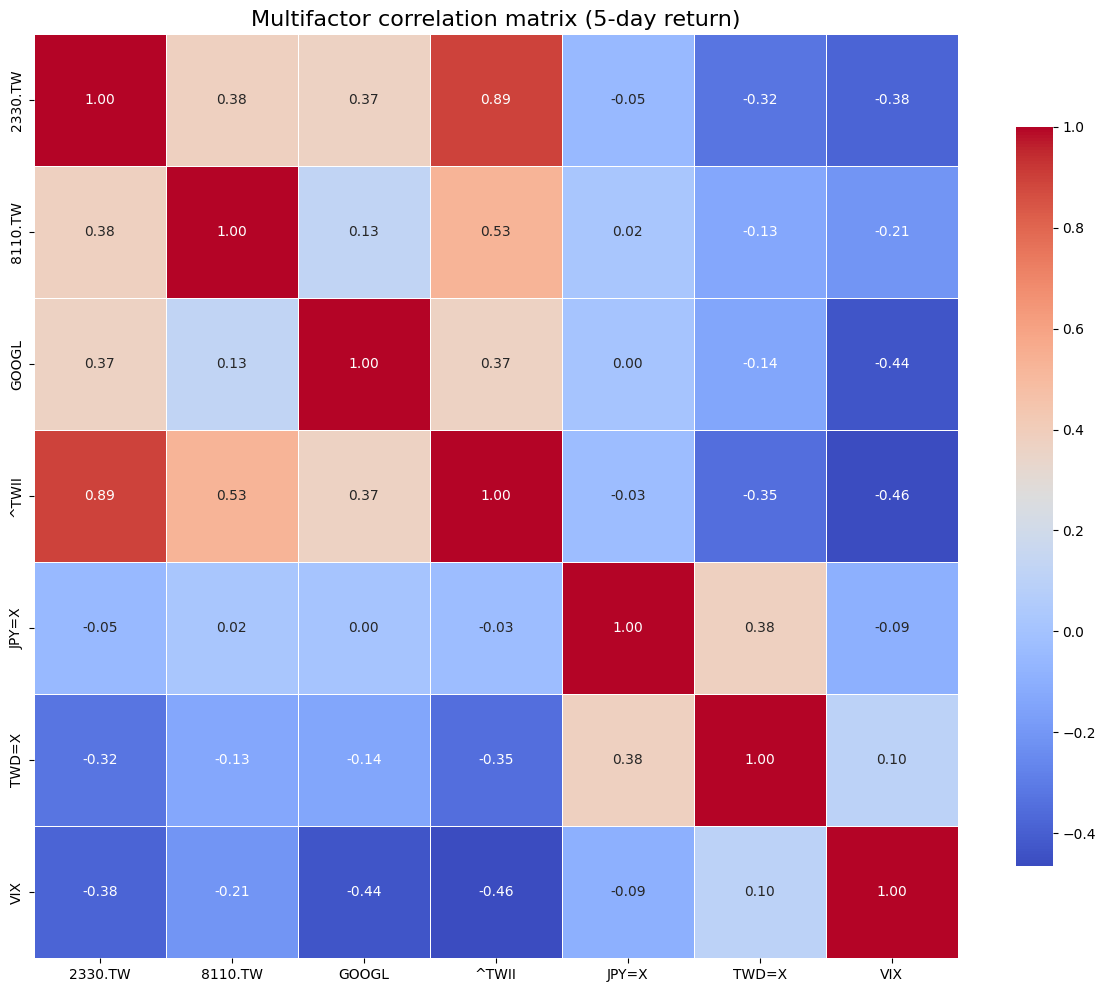


--- 相關性分析完成 ---
請查看相關性熱圖，特別是 8110.TW 與其他因子的關係。


In [1]:
# -*- coding: UTF-8 -*-
"""
======================================================================
多因子相關性分析 (Correlated Factor Analysis)
目標：準備並計算華東 (8110.tw) 及其相關資產的相關性矩陣
======================================================================
"""
import numpy as np
import pandas as pd
# 使用 yfinance 代替 pandas_datareader.data 來下載股價數據
import yfinance as yf
import pandas_datareader.data as web # 仍然用於 FRED 數據 (如 VIX, 匯率)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# --- 1. 定義標的和因子 ---
TARGET_STOCK = '8110.TW'  # 華東
# 相關股票：台股大盤、同產業龍頭、重要客戶或供應商
STK_TICKERS = [TARGET_STOCK, '^TWII', 'MU', 'GOOGL']
# 貨幣對：使用美元/台幣 (TWD=X) 和美元/日圓 (日圓是亞洲電子業重要參考)
CCY_TICKERS = ['TWD=X', 'JPY=X']
# 指數：全球大盤、恐慌指數
IDX_TICKERS = ['^GSPC', 'VIXCLS'] # ^GSPC = S&P 500, VIXCLS = FRED VIX

# 數據週期 (5年)
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=365 * 5)).strftime('%Y-%m-%d')

# --- 2. 數據下載 ---
print("正在下載多因子數據...")

download_success = True # 用於追蹤數據下載是否成功

try:
    # 下載股票數據 (使用 yfinance)
    stk_data_ohlc = yf.download(STK_TICKERS, start=START_DATE, end=END_DATE, progress=False)

    # 提取 Adjusted Close 價格，如果沒有則使用 Close
    if isinstance(stk_data_ohlc.columns, pd.MultiIndex) and 'Adj Close' in stk_data_ohlc.columns.get_level_values(0):
        stk_adj_close = stk_data_ohlc['Adj Close']
    elif isinstance(stk_data_ohlc.columns, pd.MultiIndex) and 'Close' in stk_data_ohlc.columns.get_level_values(0):
        stk_adj_close = stk_data_ohlc['Close']
    elif 'Adj Close' in stk_data_ohlc.columns:
        stk_adj_close = stk_data_ohlc['Adj Close']
    elif 'Close' in stk_data_ohlc.columns:
        stk_adj_close = stk_data_ohlc['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' column found in stock data.")

    # 下載貨幣數據 (使用 yfinance for TWD/JPY)
    ccy_data_yf_raw = yf.download(CCY_TICKERS, start=START_DATE, end=END_DATE, progress=False)
    if isinstance(ccy_data_yf_raw.columns, pd.MultiIndex) and 'Adj Close' in ccy_data_yf_raw.columns.get_level_values(0):
        ccy_data_yf = ccy_data_yf_raw['Adj Close']
    elif isinstance(ccy_data_yf_raw.columns, pd.MultiIndex) and 'Close' in ccy_data_yf_raw.columns.get_level_values(0):
        ccy_data_yf = ccy_data_yf_raw['Close']
    elif 'Adj Close' in ccy_data_yf_raw.columns:
        ccy_data_yf = ccy_data_yf_raw['Adj Close']
    elif 'Close' in ccy_data_yf_raw.columns:
        ccy_data_yf = ccy_data_yf_raw['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' column found in currency data.")

    # 下載 FRED 指數數據 (VIXCLS)
    vix_data_fred = web.DataReader('VIXCLS', 'fred', START_DATE, END_DATE)

except Exception as e:
    print(f"數據下載失敗，請檢查代碼或網路連線: {e}")
    download_success = False


# --- 3. 數據準備與合併 ---
if download_success:
    print("正在準備和合併數據...")

    # 將所有價格數據對齊並合併
    all_prices = pd.concat([stk_adj_close, ccy_data_yf, vix_data_fred], axis=1)

    # 重命名 VIXCLS 確保一致性
    all_prices.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
    # 確保所有列名都是字符串
    all_prices.columns = [str(col) for col in all_prices.columns]

    # 計算 5 日回報率 (日頻)
    return_period = 5
    dataset = np.log(all_prices).diff(return_period).dropna()

    # --- 4. 執行相關性分析 ---
    print("正在計算相關性矩陣...")

    # 計算相關性矩陣
    correlation = dataset.corr()

    # 繪製相關性熱圖
    plt.figure(figsize=(15, 12))
    plt.title('Multifactor correlation matrix (5-day return)', fontsize=16)
    sns.heatmap(
        correlation,
        vmax=1.0,
        square=True,
        annot=True,
        fmt=".2f", # 顯示兩位小數
        cmap='coolwarm', # 顏色地圖，使用 coolwarm 顯示正負相關
        linewidths=.5, # 增加線條間隔
        cbar_kws={"shrink": .8}
    )
    plt.show()

    print("\n--- 相關性分析完成 ---")
    print("請查看相關性熱圖，特別是 8110.TW 與其他因子的關係。")
else:
    print("數據下載失敗，無法進行後續分析。")